https://drive.google.com/drive/folders/1Qhr6vo5zB3hdzpEZ8oG243FlVhLYfn4X?usp=sharing

https://tbrain.trendmicro.com.tw/Competitions/Details/20

In [3]:
!pip install --upgrade numpy

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


記得修改cd路徑 這邊ai cup是我自訂的資料夾名稱，副檔會直接產生在colab notebooks下，所以將ai cup這個路徑去掉在執行

In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/ai cup

/content/drive/MyDrive/Colab Notebooks/ai cup


In [ ]:
%matplotlib inline
! unzip -q training.zip -d dataset

原始連結:
[Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
==============================================
**原文作者**: `Sasank Chilamkurthy <https://chsasank.github.io>`

本次範例程式取自上述的Pytorch tutorial, 示範了如何使用既有的分類模型finetune到自己的downstream task上。 比起重新從一個隨機初始化的參數來開始你的訓練，預訓練模型提供了訓練好的參數來讓你站在巨人的肩膀上，直接享受前人辛勞下的果實(例: [ImageNet dataset](https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description)就包含了128萬張圖片作為訓練集)。 而這樣的模型訓練方式我們稱之為 **遷移式學習**，

遷移式學習主要有兩種常見情況:

-  **根據自身資料集Finetuning在原先的NN上**

-  **將遷移式模型作為特徵提取器**

([說明](https://cs231n.github.io/transfer-learning/)取自這)

兩者的差別在於將預訓練模型作為特徵提取器時會freeze輸出層以外的layers. 而在本次範例中使用的會是Finetuning在原先的NN上，即連同輸出層以外的神經層也會一起訓練。




模型訓練
---------

模型訓練的話流程大致都差不多，不免俗前處理、資料讀取進Dataloader、送入模型訓練並最後讓模型去預測。 在我們此次蘭花分類競賽即是讓模型透過輸入圖片(input image)以及對應的標籤(label)，來將不同圖片的資訊送入輸入層(input layer)，並讓後續的隱藏層(hidden layer)做計算(註:隱藏層的層數可以是零或非零整數)，最後再將計算結果送到輸出層。 而Loss的計算即是將輸出層的輸出結果與標籤做計算，在分類模型中常見的loss計算方式為CrossEntropyLoss. 

由於從頭訓練一個模型需要更長的時間去做訓練以及參數的調整，所以我們使用別人訓練好的模型，並將自身的資料在模型上微調(finetuning)。
那麼，我們首先先執行整個程式，然後在等待執行時間的同時分別介紹各個區塊的用途及目的。


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


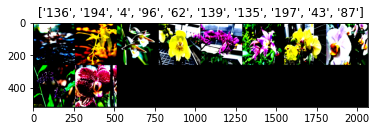

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Using device cuda:0



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

#parameters:23956763
batch_size:10
Epoch 1/20
----------
train Loss: 5.3331 Acc: 0.0176
val Loss: 4.7005 Acc: 0.1081
Epoch 2/20
----------
train Loss: 4.4246 Acc: 0.1396
val Loss: 3.5489 Acc: 0.3059
Epoch 3/20
----------
train Loss: 3.4934 Acc: 0.2890
val Loss: 2.6442 Acc: 0.4186
Epoch 4/20
----------
train Loss: 2.7173 Acc: 0.4729
val Loss: 2.0908 Acc: 0.5114
Epoch 5/20
----------
train Loss: 2.1295 Acc: 0.6008
val Loss: 1.6725 Acc: 0.6073
Epoch 6/20
----------
train Loss: 1.6589 Acc: 0.7299
val Loss: 1.3808 Acc: 0.6499
Epoch 7/20
----------
train Loss: 1.2275 Acc: 0.8239
val Loss: 1.1367 Acc: 0.7078
Epoch 8/20
----------
train Loss: 0.9511 Acc: 0.9185
val Loss: 1.0923 Acc: 0.7336
Epoch 9/20
----------
train Loss: 0.9059 Acc: 0.9439
val Loss: 1.0870 Acc: 0.7382
Epoch 10/20
----------
train Loss: 0.8590 Acc: 0.9491
val Loss: 1.0189 Acc: 0.7656
Epoch 11/20
----------
train Loss: 0.8320 Acc: 0.9569
val Loss: 1.0345 Acc: 0.7580
Epoch 12/20
----------
train Loss: 0.8114 Acc: 0.9680
val Los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()   # interactive mode
#os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

def train_model(model, criterion, device, dataloaders, dataset_sizes, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    plt.figure(0)
    plt.plot(range(1,num_epochs+1,1), np.array(train_loss), 'r-', label= "train loss") #relative global step
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(f"./train_loss.png")

    plt.figure(1)
    plt.plot(range(1,num_epochs+1,1), np.array(valid_loss), 'b-', label= "eval loss") #--evaluate_during_training True 在啟用eval
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(f"./eval_loss.png")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    #torch.save(model.state_dict(),"model.pt")
    return model

def visualize_model(model, device, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    plt.figure(figsize=(18,9))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1

                img_display = np.transpose(inputs.cpu().data[j].numpy(), (1,2,0)) #numpy:CHW, PIL:HWC
                plt.subplot(num_images//2,2,images_so_far),plt.imshow(img_display) #nrow,ncol,image_idx
                plt.title(f'predicted: {class_names[preds[j]]}')
                plt.savefig("test.jpg")
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    #原先Normalize是對每個channel個別做 減去mean, 再除上std
    inp1 = std * inp + mean

    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.imshow(inp1)
    if title is not None:
        plt.title(title)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def main():
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((256,256) ),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((256,256) ),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    data_dir = './dataset/training'

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
    batch_size = 10
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                 shuffle=True, num_workers=2)
                  for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Get a batch of training data
    inputs, classes = next(iter(dataloaders['train']))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[class_names[x] for x in classes])

    print(f"Using device {device}\n")
    #model=======================================================================
    # #ResNet50
    model_ft = models.resnet50(pretrained=True)
    #print(model_ft)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, len(class_names))

    model_ft = model_ft.to(device)
    parameter_count = count_parameters(model_ft)
    print(f"#parameters:{parameter_count}")
    print(f"batch_size:{batch_size}")
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    model_ft = train_model(model_ft, criterion, device, dataloaders, dataset_sizes, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

    visualize_model(model_ft, device, dataloaders, class_names)

if __name__ == '__main__':
    main()


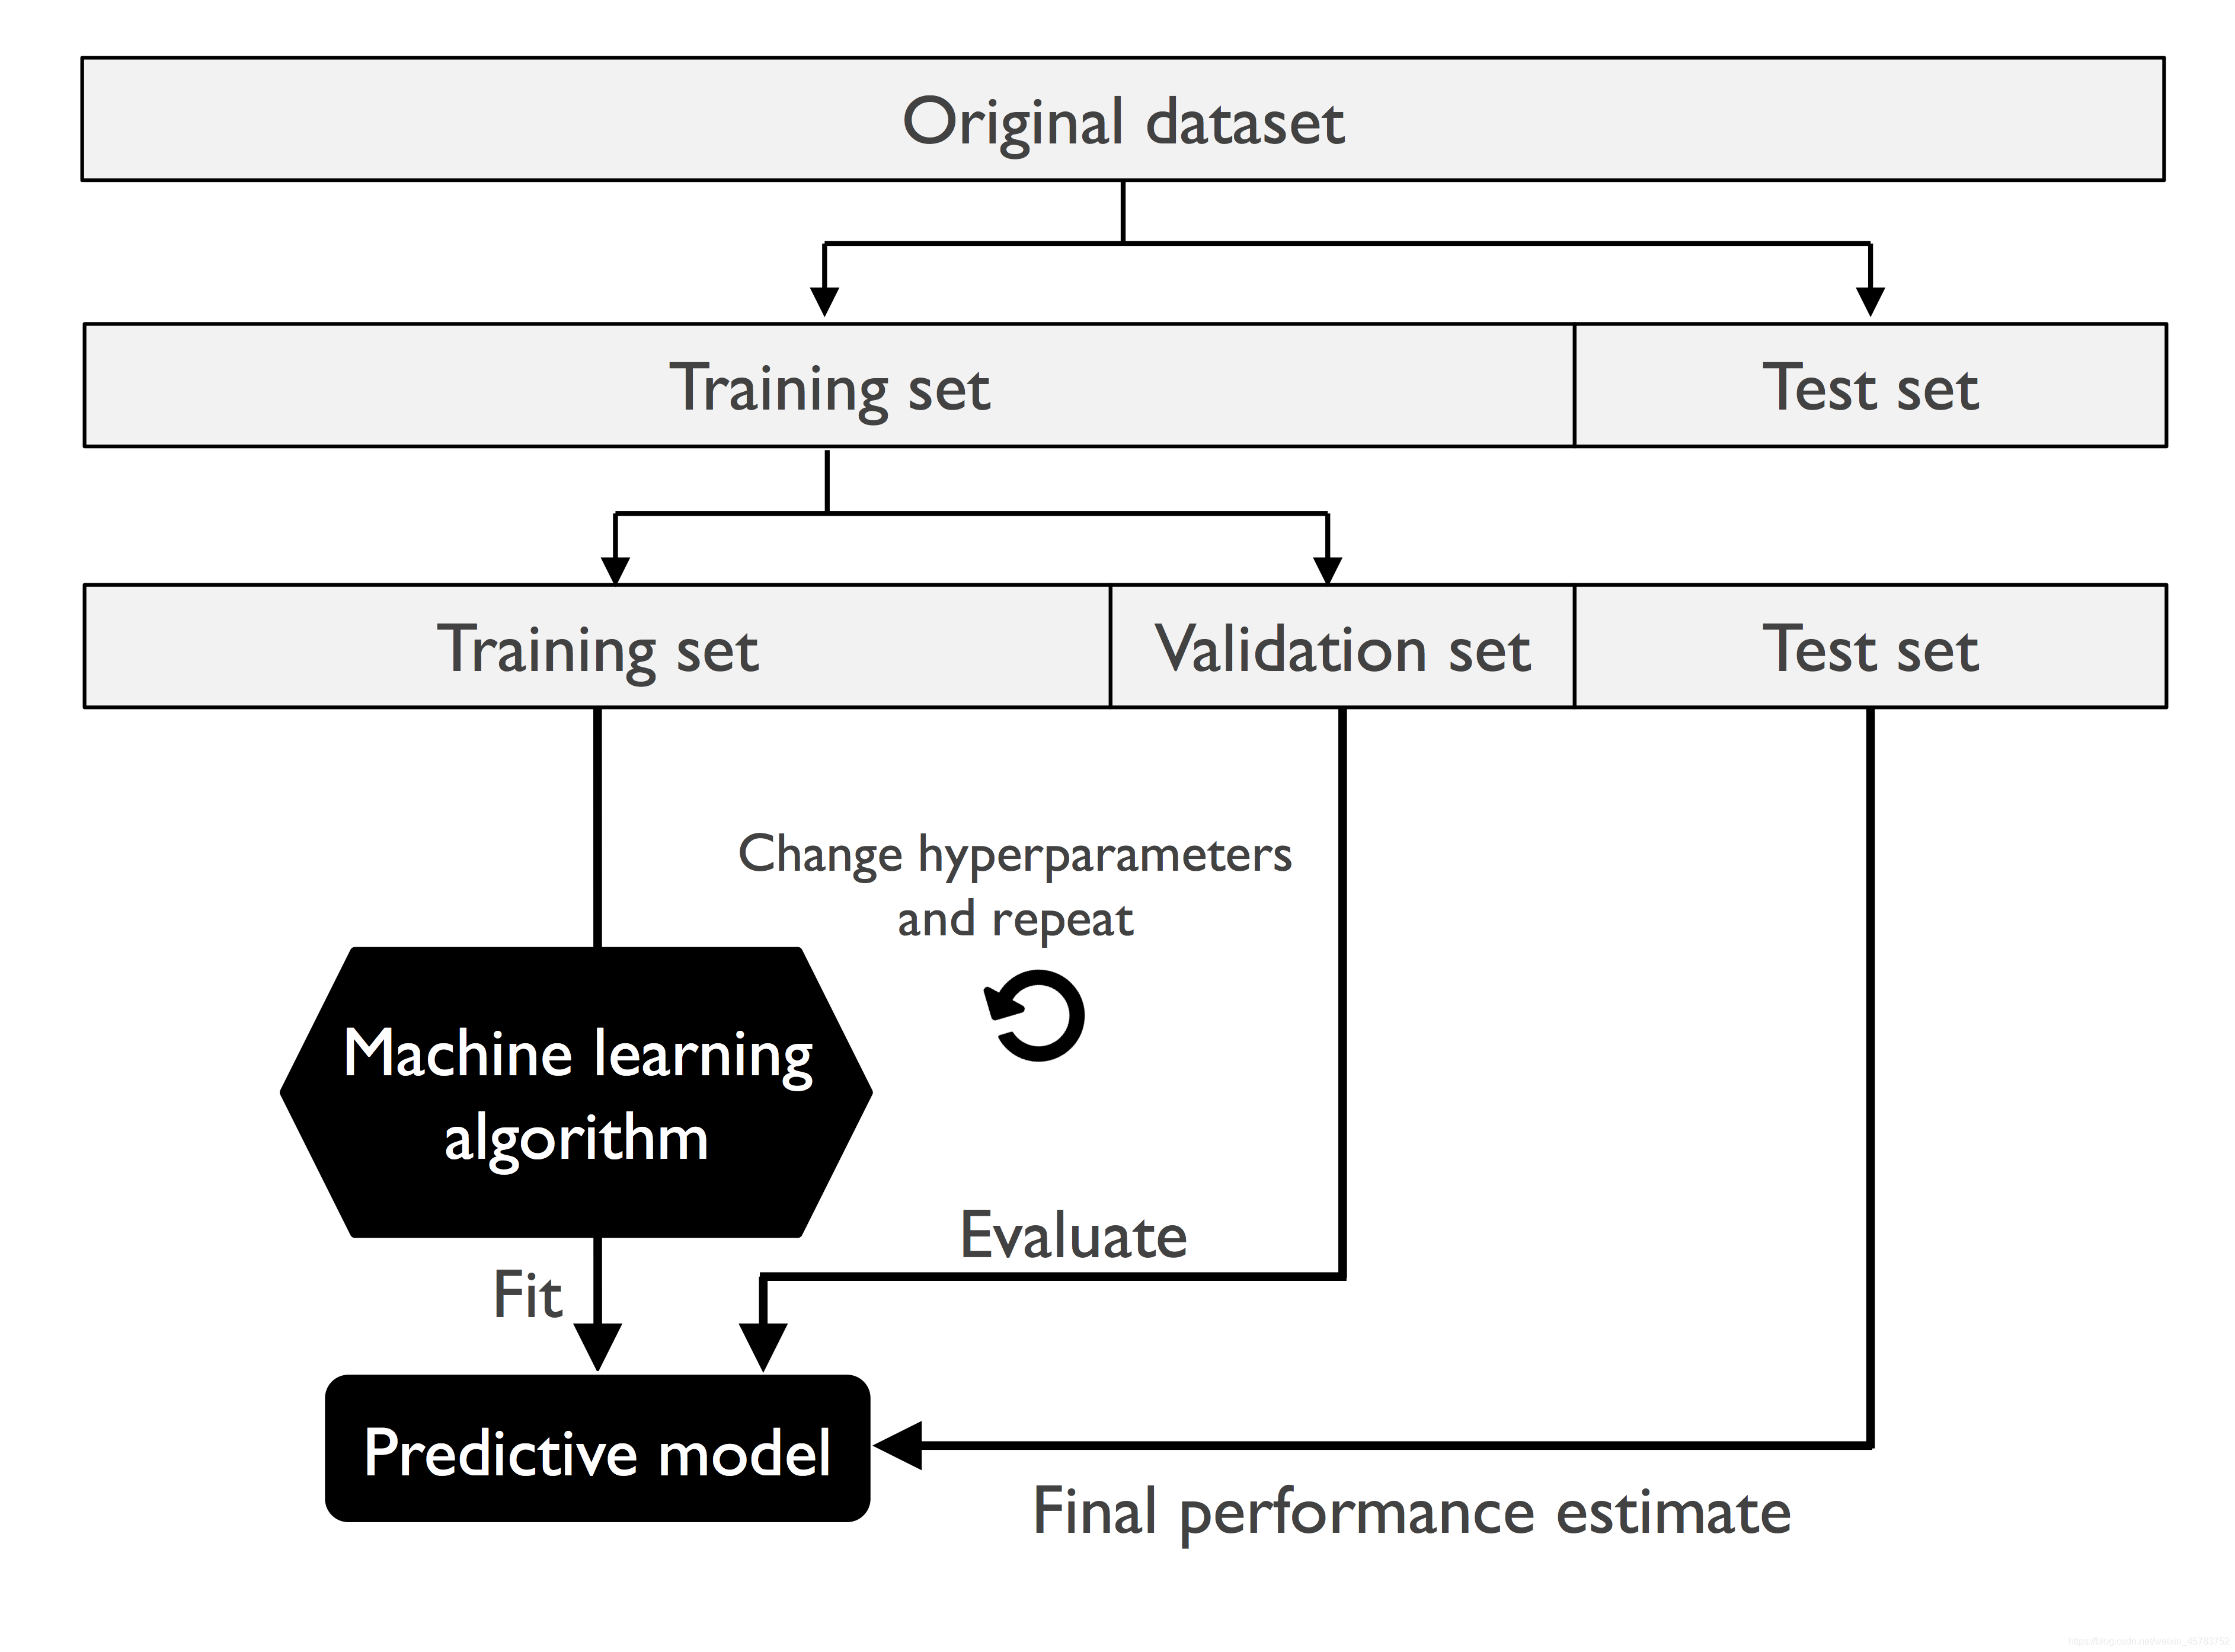

資料前處理
---------

一部分的圖像前處理需要影像處理的相關知識，但torchvision.transforms提供了不少資料轉換的套件來讓我們使用。更多的前處理方法可以參考OpenCV以及PIL的套件。

首先transforms.Compose可以把多個transforms的動作以list的方式保存並依序執行，使code的部分整潔了不少也看起來更整齊有邏輯。那麼接下來分別介紹各個API的用途:
- transform.Resize:由於神經網路要求輸入格式一致，所以我們將輸入的圖片大小統一。(e.g. 1024\*768的圖片轉換成256\*256) 
- transform.RandomHorizontalFlip(p=0.5):p機率將某張圖片做水平翻轉，p預設為0.5
- transform.ToTensor: 由於torchvision.transform預設的圖片格式是PIL格式，所以使用ToTensor()來將圖片轉成pytorch的tensor以進行後續對圖片中的像素點的操作
- transform.Normalize: 以平均值(mean)和標準差(std)來對tensor image做正規化，這邊由於使用的預訓練模型都是使用ImageNet的資料集，所以以該資料集的mean, std來對我們的輸入圖片做正規化


https://pytorch.org/vision/stable/_modules/torchvision/transforms/transforms.html#ToTensor

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256) ),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256) ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transforms

{'train': Compose(
     Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
     RandomHorizontalFlip(p=0.5)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ), 'val': Compose(
     Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 )}

讀取資料
---------

torch.utils.data的套件提供了方便的API來快速建置training set和validation set.
 
datasets.ImageFolder直接將路徑下的子目錄當作一個類別(class), <br>
例如:
  
        |___datasets
        |   |____train
        |   |    |____class1
        |   |    |    |____bf1.jpg
        |   |    |    |____bf2.jpg
        |   |    |    |____bf3.jpg
        |   |    |        ⋮
        |   |    |        ⋮
        |   |    |____class2
        |   |        |
        |   |        |____uf1.jpg
        |   |        |____uf2.jpg
        |   |      ⋮      ⋮
        |   |      ⋮      ⋮
        |   |
        |   |____val
        |      |____class1
        |      |
        |      |____class2
        |           |____bf666.jpg
        |           |____bf888.jpg
                  ⋮
                  ⋮
                  ⋮
              意思到了就好





In [ ]:
data_dir = './dataset/orchid/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                  data_transforms[x])
                  for x in ['train', 'val']}
print(image_datasets)
batch_size = 32
dataloaders = {x: torch.utils.data.DataLoader(\
              image_datasets[x], batch_size=batch_size,
              shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


{'train': Dataset ImageFolder
    Number of datapoints: 780
    Root location: ./dataset/orchid/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 2403
    Root location: ./dataset/orchid/val
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


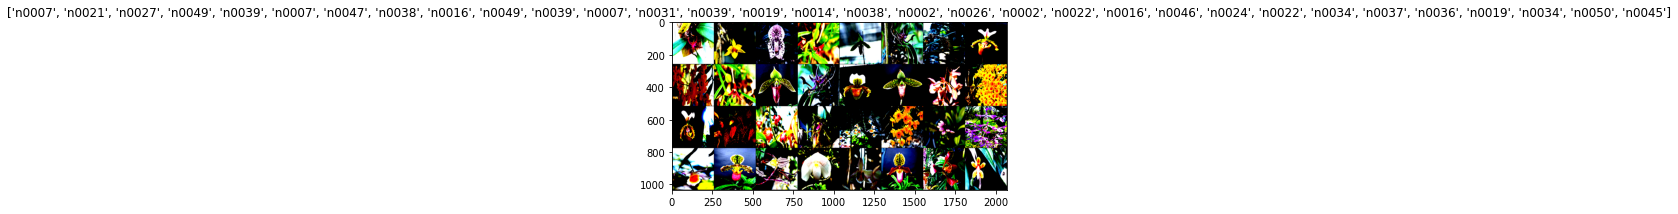

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


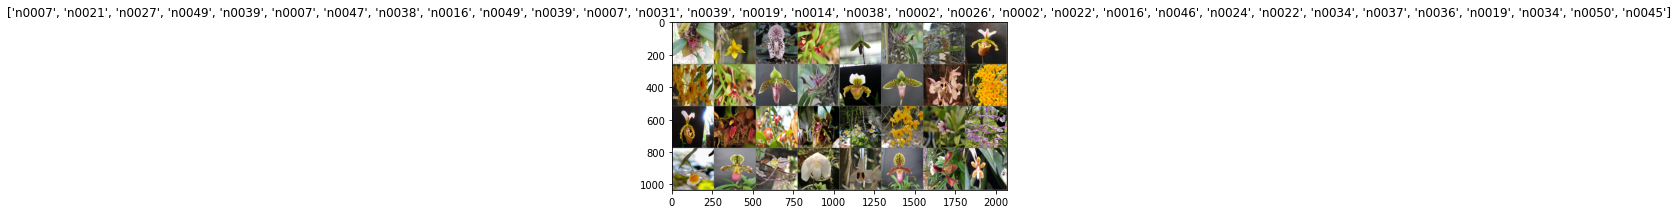

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    #原先Normalize是對每個channel個別做 減去mean, 再除上std
    inp1 = std * inp + mean

    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.imshow(inp1)
    if title is not None:
        plt.title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

模型訓練
------------------

有時候不一定最後一個epoch會是最好的結果，這時候可以用deepcopy的方式把在validation set中表現最好的其中一個模型參數存下來。(用shallow copy的話有可能還是會被之後的訓練改到)


-  Optimizer: 根據當前step得到的梯度去更新參數,更新方法與程度和scheduler有關  
-  Scheduler: 調整learning rate, 如果想在每個step更新那就和optimizer.step()一起呼叫，若想在每個epoch才更新一次，則在epoch迴圈呼叫，這邊使用的是後者。




In [ ]:
def train_model(model, criterion, device, dataloaders, dataset_sizes, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    plt.figure(0)
    plt.plot(range(1,num_epochs+1,1), np.array(train_loss), 'r-', label= "train loss") #relative global step
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(f"./train_loss.png")

    plt.figure(1)
    plt.plot(range(1,num_epochs+1,1), np.array(valid_loss), 'b-', label= "eval loss") #--evaluate_during_training True 在啟用eval
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(f"./eval_loss.png")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    #torch.save(model.state_dict(),"model.pt")
    return model

微調模型
----------------------

如果是使用遷移式學習，對模型的微調是不可避的。這邊我們透過改變最後一層輸出層的輸出大小(output size)來符合我們需要的分類(#total class)

optimizer中的lr即learning rate, momentum表示當梯度下降方向與上次相同時，則加大下降幅度;更改時，則降低下降幅度




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
#例如蘭花有219類 則把最後一個fc layer改成輸出有219個
model_ft.fc = nn.Linear(num_ftrs, 219)

model_ft = model_ft.to(device)
print(model_ft)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  